# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекc Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
# импортирую библиотеку
import pandas as pd

In [2]:
# открываю таблицу и запрашиваю все атрибуты 
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Вывод:**
* Вижу довольно большие пропуски значений, причем во многих столбцах.
* Очень напрягают указанные типы данных, каким-то образом у нас количество этажей и число балконов это дробные числа, что в принципе невозможно!


## Предобработка данных

In [3]:
# Переименуем столбы
cols = ['total_images',            
'last_price',              
'total_area',              
'first_day_exposition',   
'rooms',                   
'ceiling_height',          
'floors_total',            
'living_area',             
'floor',                   
'is_apartment',            
'studio',                 
'open_plan',               
'kitchen_area',            
'balcony',               
'locality_name',           
'airports_nearest',        
'city_centers_nearest',     
'parks_around_3000',       
'parks_nearest',           
'ponds_around_3000',       
'ponds_nearest',           
'days_exposition'] 
data.set_axis(cols, axis='columns', inplace=True)

In [4]:
# Убедимся, что столбцы переименованы
data.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'studio',
 'open_plan',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'city_centers_nearest',
 'parks_around_3000',
 'parks_nearest',
 'ponds_around_3000',
 'ponds_nearest',
 'days_exposition']

**1. Для начала определим пропущенные значения и заполним их.**

In [5]:
# смотрим количество пропущенных значений
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
# КОД РЕВЬЮЕРА

pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
is_apartment,88.290000
parks_nearest,65.910000
ponds_nearest,61.560000
balcony,48.610000
ceiling_height,38.800000
airports_nearest,23.380000
city_centers_nearest,23.290000
parks_around_3000,23.280000
ponds_around_3000,23.280000
days_exposition,13.420000


Видим ужасную вещь, огромное количество пропусков почти в каждом столбце, заполнять эти пропуски я буду медианным значением. Для большей точности я буду группировать наши столбики с другими, которые каким либо образом связаны. Но в столбцах: `balcony`, `is_apartment` и `locality_name` этот метод не сработает,  с ними мы разберемся позднее!

In [7]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


In [8]:
# заполняем все наши пропуски в столбцах медианными значениями  и сразу проверяем
# проверка заполнения
ceiling_height = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height)
data['ceiling_height']

0        2.70
1        2.65
2        2.65
3        2.65
4        3.03
         ... 
23694    3.70
23695    2.65
23696    2.65
23697    3.00
23698    2.50
Name: ceiling_height, Length: 23699, dtype: float64

Мы заполнили лишь 1 столбец, видим, что медиана равна 2.65м, вполне нормально для высоты потолков. Проделаем это с остальными пропусками.

In [9]:
# заполняем все пропуски медианным значением, использую другие столбцы
data['floors_total'] = data['floors_total'].fillna(data.groupby('floor')['floors_total'].transform('median'))

In [11]:
# заполняем все наши пропуски в столбцах медианными значениями
# проверка заполнения
data['living_area'] = data['living_area'].fillna(data.groupby('rooms')['living_area'].transform('median'))
data['living_area']

0        51.0
1        18.6
2        34.3
3        45.0
4        32.0
         ... 
23694    73.3
23695    38.0
23696    29.7
23697    30.5
23698    12.3
Name: living_area, Length: 23699, dtype: float64

In [12]:
# заполняем все наши пропуски в столбцах медианными значениями 
kitchen_area = data.groupby('locality_name')['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area)

In [13]:
# заполняем все наши пропуски в столбцах медианными значениями  
airports_nearest = data['airports_nearest'].median()
data['airports_nearest'] = data['airports_nearest'].fillna(airports_nearest)

In [14]:
# заполняем все наши пропуски в столбцах медианными значениями 
cityCenters_nearest = data['city_centers_nearest'].median()
data['city_centers_nearest'] = data['city_centers_nearest'].fillna(cityCenters_nearest)
data['city_centers_nearest']

0        16028.0
1        18603.0
2        13933.0
3         6800.0
4         8098.0
          ...   
23694     4232.0
23695    13098.5
23696    13098.5
23697    10364.0
23698    13098.5
Name: city_centers_nearest, Length: 23699, dtype: float64

In [15]:
# заполняем все наши пропуски в столбцах медианными значениями 
parks_around3000 = data['parks_around_3000'].median()
data['parks_around_3000'] = data['parks_around_3000'].fillna(parks_around3000)

In [16]:
# заполняем все наши пропуски в столбцах медианными значениями 
parks_nearest = data['parks_nearest'].median()
data['parks_nearest'] = data['parks_nearest'].fillna(parks_nearest)

In [17]:
# заполняем все наши пропуски в столбцах медианными значениями 
ponds_around3000 = data['ponds_around_3000'].median()
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(ponds_around3000)

In [18]:
# заполняем все наши пропуски в столбцах медианными значениями 
ponds_nearest = data['ponds_nearest'].median()
data['ponds_nearest'] = data['ponds_nearest'].fillna(ponds_nearest)

In [19]:
# заполняем все наши пропуски в столбцах медианными значениями 
days_exposition= data['days_exposition'].median()
data['days_exposition'] = data['days_exposition'].fillna(days_exposition )

In [20]:
# проверка на пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest            0
city_centers_nearest        0
parks_around_3000           0
parks_nearest               0
ponds_around_3000           0
ponds_nearest               0
days_exposition             0
dtype: int64

Как мы можем наблюдать, были заменены все пропуски на медианные значения везде, где это можно было сделать. Но у нас остались еще 3 столбика, к каждому из которых нужно подходить отдельно и так, начнем.

Начнем со столбика `locality_name`, так как город мы никак не сможем узнать или вписать какой хотим, стоит поставить прочерк, не повод удалять важные данные.

In [21]:
data['locality_name'] = data['locality_name'].fillna('-')

Следующий столбец `balcony`, мы видим в нем 11.5к пропусков, можно догадаьбся, что скорее всего владельцы не указывали количество балкон, потому что их просто нет, заполним все пропуски этого столбца нулевыми значениями!

In [22]:
data['balcony'] = data['balcony'].fillna('0')

Остался последний столбец `is_apartment`, заполним пропуски фразой: ложные записи.

In [23]:
data['is_apartment'] = data['is_apartment'].fillna('False records')

На этом мы закончили заполнять пропуски, проверим остались ли они в нашей таблице!

In [24]:
#проверка на пропуски 
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area            2278
balcony                    0
locality_name              0
airports_nearest           0
city_centers_nearest       0
parks_around_3000          0
parks_nearest              0
ponds_around_3000          0
ponds_nearest              0
days_exposition            0
dtype: int64

Отлично, мы справились со всеми пропусками!

  **Вывод:**
* В нашей таблицы я обнаружил очень много пропусков, которые пришлось заменять на разные значения, в большей степени они были заменены на медианные значения, но были отдельные столбцы, к которым пришлось подходить индивидуально. Такие столбцы как: `balcony`, `is_apartment`, `locality_name` пришлось заполнять значениями, которые исходя из логики подходили в каждый отдельный момент.
* Причины, которые могли привести к пропускам данных: многие пропуски возникли из-за того, что сами люди не указывали некоторые данные (Пример: число балконов). Так же пропуски могли возникнуть из-за отсутствие картографических данных, про другие причины с уверенностью не могу сказать.

**2. Настало время заменить типы данных там, где это необходимо.**

In [25]:
# открываю таблицу и запрашиваю все атрибуты 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  object 
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

В результате не долгой мыслительной деятельности понимаю, что много ошибок в типах данных, заменим их на правильные!

In [26]:
# заменяем все ложные типы на правильные
data['last_price'] = data['last_price'].astype('int64')
data['first_day_exposition'] = data['first_day_exposition'].astype('datetime64')
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['airports_nearest'] = data['airports_nearest'].astype('int64')
data['city_centers_nearest'] = data['city_centers_nearest'].astype('int64')
data['parks_around_3000'] = data['parks_around_3000'].astype('int64')
data['parks_nearest'] = data['parks_nearest'].astype('int64')
data['ponds_around_3000'] = data['ponds_around_3000'].astype('int64')
data['ponds_nearest'] = data['ponds_nearest'].astype('int64')
data['days_exposition'] = data['days_exposition'].astype('int64')

Посмотрим итоговый результат!

In [27]:
# проверка изменения типов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

**Вывод:** 

 Я решил изменить эти столбцы по следующему принципу:
* Во всех пунктах, где нужно было указать расстояние до какого-либо объекта в метрах я поставил тип данных "целые числа", так как там нет смысла указывать сантиметры, значения и так будут точными.
* Так же был столбец `first_day_exposition`, в котором мы записываем дату публикации, здесь должен быть тип данных "datetime64".
* И, конечно, были столбцы по типу: указать число балконов, цену снятия, дни размещения объявления, число чего-либо и т.д., в этих столбиках просто не может быть типа данных "float64", поменял на "int64".

**3. Самое время проверить нашу таблицу на какие-нибудь аномалии или неточности!**

На вид все наши значения выглядят без каких-либо ошибок, но мне удалось найти несколько интересных моментов:
* Я заметил, что у нас есть квартиры аж с 5 балконами и причем их 304, допустим такие квартиры и есть, но их общая площадь должна быть огромных масштабов, но что мы видим при просмотре средних площадей для каждого количества балконов?

In [28]:
# ищем все среднии площади квартир для каждого этажа.
def relation(category): 
    return data.groupby(category)['total_area'].mean().to_frame().sort_values(by='total_area')
relation('balcony')


,total_area
balcony,
2,55.998931
1,57.149449
0,61.461731
5,80.837171
4,81.426230
3,88.077531


Никогда не поверю, что при 80 м^2 можно вместить аж 5 балконов, это невозможно. Зададим минимальную площадь 100 м^2 для квартир с 5 балконами и посмотрим, сколько квартир имеют общую площадь, менье 100.

In [29]:
# считаем количество квартир  с нашим условием.
len(data.query('balcony == 5 and total_area <= 100'))

255

Мы получили 255 квартир, имеющих общую площадь меньше 100 м^2 и при этом в которых расположены по 5 балконов, я определенно уверен, что это ошибка и решил заявить о ней.

Также обнаружил еще одну странную вещь!

In [30]:
# узнаем, сколько балконов находится в квартирах
data['balcony'].value_counts()

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

Очень странно наблюдать тот факт, что квартир с 5 балконами больше, чем квартир с 3 и 4 вместе взятыми, так же решил заявить о возможной ошибке.

И последняя странность которую я заметил, заключается в следующем.

In [31]:
# узнаем, какое количество дней было размещено объявление о квартирах.
data['days_exposition'].value_counts().head(10)

95    3245
45     880
60     538
7      234
30     208
90     204
4      176
3      158
5      152
14     148
Name: days_exposition, dtype: int64

Очень странно наблюдать статистику времени размещения объявлений. В большей степени квартиры снимались за такое знаковое количество дней, как месяц, 2 месяца, неделя, 2 недели, полмесяца. Создается такое ощущение, что дни специально округлялись до таких дат, не очень верю в такие совпадения и сообщаю о возможной неточности.

**Вывод:**
* появились большие вопросы по поводу количества балконов и их отношения к общей площади и количеству комнат.
* стоит внимательно изучить информацию о днях размещения объявлений. 

**4. Проверим нашу таблицу на дубликаты.**

In [32]:
# проверка на строки_дубликаты
data.duplicated().sum()

0

Отлично, строк дубликатов нет, идем дальше.

Посмотрим отношение наших объявлений к каждому столбцу.

In [33]:
# создадим цикл, который береберет все столцы.
for column_name in data.columns:
    display(data[column_name].value_counts())

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
28       4
32       4
29       3
50       3
27       2
35       2
30       2
31       2
39       1
25       1
42       1
37       1
Name: total_images, dtype: int64

4500000     342
3500000     291
4000000     260
4300000     260
4200000     259
           ... 
1320000       1
19150000      1
6649000       1
10296437      1
11615600      1
Name: last_price, Length: 2978, dtype: int64

45.00     419
42.00     383
60.00     347
31.00     346
44.00     345
         ... 
44.24       1
56.85       1
37.92       1
115.60      1
55.06       1
Name: total_area, Length: 2182, dtype: int64

2018-02-01    368
2017-11-10    240
2017-10-13    124
2017-09-27    111
2018-03-26     97
             ... 
2015-05-17      1
2017-01-06      1
2016-12-30      1
2016-07-06      1
2015-03-27      1
Name: first_day_exposition, Length: 1491, dtype: int64

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

2.65     9871
2.50     3515
2.60     1646
2.70     1574
3.00     1112
         ... 
4.25        1
3.39        1
3.93        1
10.30       1
4.65        1
Name: ceiling_height, Length: 183, dtype: int64

5     5807
9     3770
16    1388
12    1362
4     1200
10    1191
25    1083
6      918
17     841
3      668
7      592
14     553
18     505
24     474
8      390
2      383
15     365
23     352
19     339
22     290
20     271
13     229
11     203
27     164
21     158
26     124
1       25
35      24
28      21
36       3
34       1
60       1
52       1
29       1
33       1
37       1
Name: floors_total, dtype: int64

18.00    896
17.60    755
30.50    710
17.00    675
30.00    598
        ... 
96.40      1
50.26      1
43.81      1
54.43      1
16.74      1
Name: living_area, Length: 1783, dtype: int64

2     3368
3     3073
1     2917
4     2804
5     2621
6     1305
7     1218
8     1083
9     1051
10     687
12     526
11     523
13     379
15     343
14     337
16     315
17     227
18     178
19     147
21     125
22     113
20     110
23     100
24      63
25      46
26      24
27      10
28       1
29       1
32       1
30       1
33       1
31       1
Name: floor, dtype: int64

False records    20924
False             2725
True                50
Name: is_apartment, dtype: int64

False    23550
True       149
Name: studio, dtype: int64

False    23632
True        67
Name: open_plan, dtype: int64

6.00     1300
10.00    1262
8.00     1110
9.00     1101
7.00     1062
         ... 
7.12        1
13.73       1
14.74       1
53.10       1
16.74       1
Name: kitchen_area, Length: 971, dtype: int64

0    15277
1     4195
2     3659
5      304
4      183
3       81
Name: balcony, dtype: int64

Санкт-Петербург                                            15721
посёлок Мурино                                               522
посёлок Шушары                                               440
Всеволожск                                                   398
Пушкин                                                       369
                                                           ...  
деревня Пижма                                                  1
деревня Курковицы                                              1
садоводческое некоммерческое товарищество Лесная Поляна        1
деревня Тойворово                                              1
поселок Дружноселье                                            1
Name: locality_name, Length: 365, dtype: int64

26726    5546
37434      61
21928      32
44870      30
39946      30
         ... 
34454       1
16017       1
28299       1
48769       1
18565       1
Name: airports_nearest, Length: 8275, dtype: int64

13098    5520
8460       61
20802      32
10720      30
20444      27
         ... 
26602       1
30696       1
4055        1
38868       1
2047        1
Name: city_centers_nearest, Length: 7642, dtype: int64

0    15624
1     5681
2     1747
3      647
Name: parks_around_3000, dtype: int64

455     15634
441        67
392        41
173        41
456        40
        ...  
3064        1
748         1
726         1
985         1
2711        1
Name: parks_nearest, Length: 995, dtype: int64

1    11235
0     9071
2     1892
3     1501
Name: ponds_around_3000, dtype: int64

502     14609
427        70
454        41
153        40
433        39
        ...  
808         1
984         1
1144        1
25          1
1222        1
Name: ponds_nearest, Length: 1096, dtype: int64

95      3245
45       880
60       538
7        234
30       208
        ... 
1112       1
1080       1
1064       1
1032       1
1391       1
Name: days_exposition, Length: 1141, dtype: int64

Посмотрев полученную информацию, я не нашел в ней чего-то странного 

**Вывод:**
 При проверке нашей таблицы дубликаты не найдены!

## Расчёты и добавление результатов в таблицу

Найдем цену квадратного метра для каждой квартиры и добавим в отдельный столбец в нашей таблицы.

In [34]:
#  откроем нашу таблицу
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False records,...,25.00,0,Санкт-Петербург,18863,16028,1,482,2,755,95
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False records,...,11.00,2,посёлок Шушары,12817,18603,0,455,0,502,81
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False records,...,8.30,0,Санкт-Петербург,21741,13933,1,90,2,574,558
3,0,64900000,159.00,2015-07-24,3,2.65,14,45.0,9,False records,...,NaN,0,Санкт-Петербург,28098,6800,2,84,3,234,424
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False records,...,41.00,0,Санкт-Петербург,31856,8098,2,112,1,48,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False records,...,13.83,0,Санкт-Петербург,24665,4232,1,796,3,381,95
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False records,...,8.50,0,Тосно,26726,13098,0,455,1,502,45
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False records,...,NaN,0,село Рождествено,26726,13098,0,455,1,502,95
23697,13,11475000,76.75,2017-03-28,2,3.00,17,30.5,12,False records,...,23.30,2,Санкт-Петербург,39140,10364,2,173,3,196,602


In [35]:
# создаем новый столбец, в котором будут указываться целые значения цен за м^2
data['meter_price'] = data['last_price'] / data['total_area']
data['meter_price'] = data['meter_price'].astype('int64')
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False records,...,0,Санкт-Петербург,18863,16028,1,482,2,755,95,120370
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False records,...,2,посёлок Шушары,12817,18603,0,455,0,502,81,82920
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False records,...,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785
3,0,64900000,159.00,2015-07-24,3,2.65,14,45.0,9,False records,...,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False records,...,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False records,...,0,Санкт-Петербург,24665,4232,1,796,3,381,95,72490
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False records,...,0,Тосно,26726,13098,0,455,1,502,45,52542
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False records,...,0,село Рождествено,26726,13098,0,455,1,502,95,44091
23697,13,11475000,76.75,2017-03-28,2,3.00,17,30.5,12,False records,...,2,Санкт-Петербург,39140,10364,2,173,3,196,602,149511


Займемся другими столбцами!

Добавим столбы с днем, месяцем и годом.

In [36]:
# добавляем столбцы
data['day'] = data['first_day_exposition'].dt.day_name()
data['month'] = data['first_day_exposition'].dt.month_name()
data['year'] = data['first_day_exposition'].dt.year
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,day,month,year
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False records,...,16028,1,482,2,755,95,120370,Thursday,March,2019
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False records,...,18603,0,455,0,502,81,82920,Tuesday,December,2018
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False records,...,13933,1,90,2,574,558,92785,Thursday,August,2015
3,0,64900000,159.00,2015-07-24,3,2.65,14,45.0,9,False records,...,6800,2,84,3,234,424,408176,Friday,July,2015
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False records,...,8098,2,112,1,48,121,100000,Tuesday,June,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False records,...,4232,1,796,3,381,95,72490,Tuesday,March,2017
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False records,...,13098,0,455,1,502,45,52542,Monday,January,2018
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False records,...,13098,0,455,1,502,95,44091,Sunday,February,2018
23697,13,11475000,76.75,2017-03-28,2,3.00,17,30.5,12,False records,...,10364,2,173,3,196,602,149511,Tuesday,March,2017


Отлично, получилось! Идем дальше.

Узнаем этаж каждой квартиры и добавим его в таблицу.

In [37]:
# добавим этажи в нашу таблицу
# создаем функцию для определения этажа
# открываем таблицу
def floor_status(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_status'] = data.apply(floor_status, axis=1)
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,day,month,year,floor_status
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False records,...,1,482,2,755,95,120370,Thursday,March,2019,другой
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False records,...,0,455,0,502,81,82920,Tuesday,December,2018,первый
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False records,...,1,90,2,574,558,92785,Thursday,August,2015,другой
3,0,64900000,159.00,2015-07-24,3,2.65,14,45.0,9,False records,...,2,84,3,234,424,408176,Friday,July,2015,другой
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False records,...,2,112,1,48,121,100000,Tuesday,June,2018,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False records,...,1,796,3,381,95,72490,Tuesday,March,2017,другой
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False records,...,0,455,1,502,45,52542,Monday,January,2018,другой
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False records,...,0,455,1,502,95,44091,Sunday,February,2018,первый
23697,13,11475000,76.75,2017-03-28,2,3.00,17,30.5,12,False records,...,2,173,3,196,602,149511,Tuesday,March,2017,другой


In [38]:
# добавим соотношения в нашу таблицу
data['total_living_area_ratio'] = data['living_area'] / data['total_area']
data['total_kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3000,ponds_nearest,days_exposition,meter_price,day,month,year,floor_status,total_living_area_ratio,total_kitchen_area_ratio
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False records,...,2,755,95,120370,Thursday,March,2019,другой,0.472222,0.231481
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False records,...,0,502,81,82920,Tuesday,December,2018,первый,0.460396,0.272277
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False records,...,2,574,558,92785,Thursday,August,2015,другой,0.612500,0.148214
3,0,64900000,159.00,2015-07-24,3,2.65,14,45.0,9,False records,...,3,234,424,408176,Friday,July,2015,другой,0.283019,NaN
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False records,...,1,48,121,100000,Tuesday,June,2018,другой,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False records,...,3,381,95,72490,Tuesday,March,2017,другой,0.547792,0.103356
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False records,...,1,502,45,52542,Monday,January,2018,другой,0.644068,0.144068
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False records,...,1,502,95,44091,Sunday,February,2018,первый,0.523810,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17,30.5,12,False records,...,3,196,602,149511,Tuesday,March,2017,другой,0.397394,0.303583


**Вывод:**
* Посчитали данные для последующего анализа.
* Добавили их в нашу таблицу.

## Исследовательский анализ данных

1. Построим гистограммы для таких параметров как: площадь, цена, число комнат, высота потолков.

Text(0.5, 1.0, 'Гистограмма площади')

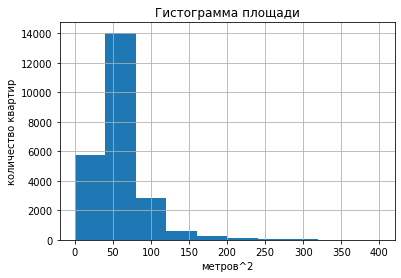

In [39]:
# стороим гистограмму для площади
import matplotlib.pyplot as plt
data['total_area'].hist(range=(0, 400))
plt.xlabel('метров^2')
plt.ylabel('количество квартир')
plt.title('Гистограмма площади')

Обычно площадь квартиры составляет от 40, до 80 м^2.

<AxesSubplot:>

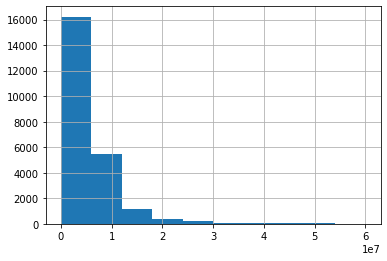

In [40]:
# строим гистограмму для цены
data['last_price'].hist(range=(0,60000000))

Мы видим, что большая часть квартир стоит до 6 млн рублей.

<AxesSubplot:>

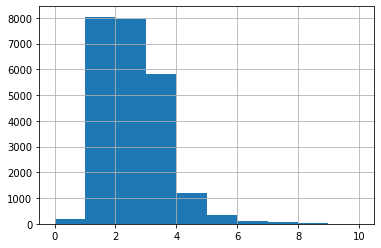

In [41]:
# строим гистограмму для числа комнат
data['rooms'].hist(range=(0, 10))

В большей степени в квартирах расположены 1-3 комнаты.

<AxesSubplot:>

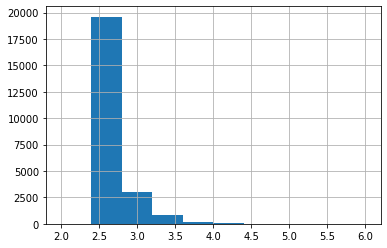

In [42]:
# строим гистограмму для высоты потолков
data['ceiling_height'].hist(range=(2, 6))

**Вывод:** 
Мы изучили все данные параметры и построили диаграммы.

В большей части квартир потолки высотой от 2,4 до 2,8 метров

2. Изучим время продажи квартиры.

<AxesSubplot:>

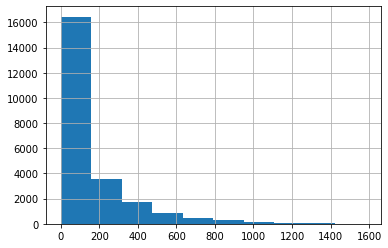

In [43]:
# построим гистограмму для времени продажи квартиры
data['days_exposition'].hist()

Мы видим, что большую часть квартир скупали в течении 150 дней, чтобы узнать все точнее найдем среднее и медиану.

In [44]:
# найдем среднее арифметическое и медиану
data['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Вывод:**
* Я привык в большей степени доверять медианному значению, а это значит, что обычна продажа квартиры занимает 95 дней.
* Можно считать, что продажи прошли очень быстро, если квартиру купили в течении 45 дней.
* Можно считать, что продажи прошли необычно долг, если квартиру купили после 199 дней.

3. Уберем редкие значения в основных столбцах.

In [45]:
# посмотрим редкие значения в столбце 'число комнат'
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

In [46]:
# сделаем срез и сохраним нормальные значения
data = data.query('rooms <= 9')
data['rooms'].value_counts()

1    8047
2    7940
3    5814
4    1180
5     326
0     197
6     105
7      59
8      12
9       8
Name: rooms, dtype: int64

Мы убрали редкие значения в столбце `rooms`, проделаем тоже самое и с другими важными столбиками.

In [47]:
# посмотрим значения в столбце 'площадь квартиры'
data['total_area'].describe()

count    23688.000000
mean        60.212056
std         34.817966
min         12.000000
25%         40.000000
50%         52.000000
75%         69.742500
max        631.200000
Name: total_area, dtype: float64

In [48]:
# уберем выбивающиеся значения
data = data.query('20 <= total_area <= 200')
data['total_area'].describe()

count    23443.00000
mean        58.21653
std         26.48311
min         20.00000
25%         40.00000
50%         52.00000
75%         69.00000
max        200.00000
Name: total_area, dtype: float64

In [49]:
# посмотрим значения в столбце `расстояние до центра города`
data['city_centers_nearest'].describe()

count    23443.000000
mean     14006.967794
std       7532.720307
min        181.000000
25%      11020.000000
50%      13098.000000
75%      15280.500000
max      65968.000000
Name: city_centers_nearest, dtype: float64

In [50]:
# уберем выбивающиеся значения
data = data.query('city_centers_nearest <= 50000')
data['city_centers_nearest'].describe()

count    23257.000000
mean     13700.483037
std       6729.539003
min        181.000000
25%      11001.000000
50%      13098.000000
75%      15176.000000
max      49984.000000
Name: city_centers_nearest, dtype: float64

**Вывод:**
 При выполнении данного задания я обнаружил множество не просто редких, а просто невозможных значений, например: в площадь квартиры 631м^2 лично я плохо верю, пришлось ставить диапазоны для наших столбцов, чтобы избавиться от таких  выбивающихся значений.

In [51]:
data['last_price'].describe()

count    2.325700e+04
mean     6.044464e+06
std      6.255662e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      3.300000e+08
Name: last_price, dtype: float64

In [52]:
data = data.query('1500000 <= last_price <= 200000000')
data['last_price'].describe()

count    2.261500e+04
mean     6.157930e+06
std      5.598776e+06
min      1.500000e+06
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      1.350000e+08
Name: last_price, dtype: float64

4. Узнаем, какие факторы больше всего влияют на стоимость.

In [53]:
corr = data[['last_price',\
           'total_area',\
           'rooms',\
           'city_centers_nearest']].corr()
corr.style

,last_price,total_area,rooms,city_centers_nearest
last_price,1.000000,0.714363,0.421124,-0.287426
total_area,0.714363,1.000000,0.786954,-0.232879
rooms,0.421124,0.786954,1.000000,-0.163505
city_centers_nearest,-0.287426,-0.232879,-0.163505,1.000000


<AxesSubplot:xlabel='rooms', ylabel='last_price'>

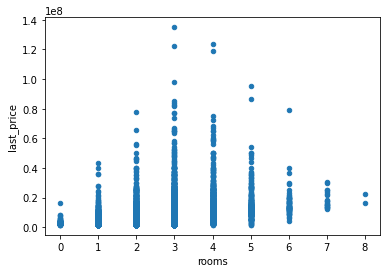

In [54]:
data.plot(kind = 'scatter', y ='last_price', x = 'rooms')

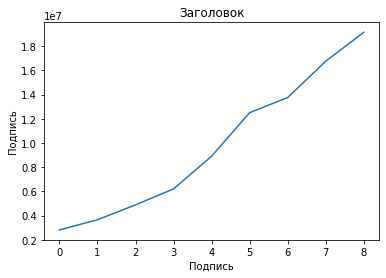

In [55]:
# КОД РЕВЬЮЕРА


data.groupby('rooms')['last_price'].median().plot()


plt.title('Заголовок')
plt.xlabel('Подпись')
plt.ylabel('Подпись')
plt.show()

<AxesSubplot:xlabel='month'>

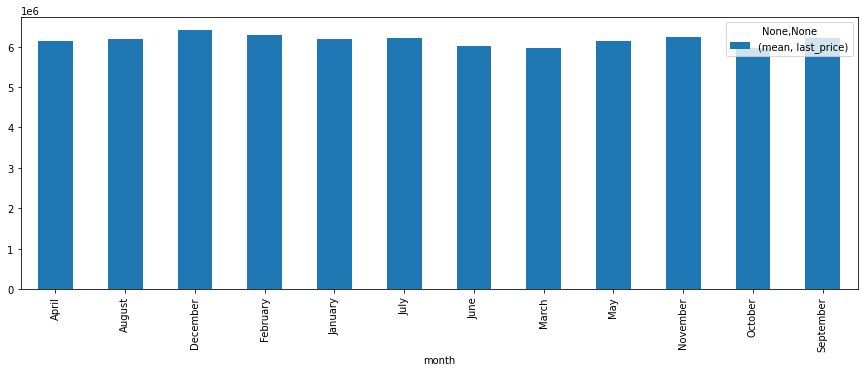

In [56]:
data_0 = data.pivot_table(index='month', values='last_price', aggfunc=['mean'])
data_0.plot(kind='bar', figsize=(15,5))

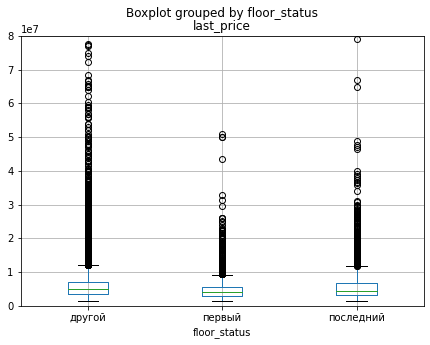

In [57]:
# посторим диаграмму размаха 
plot = data.boxplot('last_price', by='floor_status', figsize=(7,5)).set_ylim(0, 80000000)

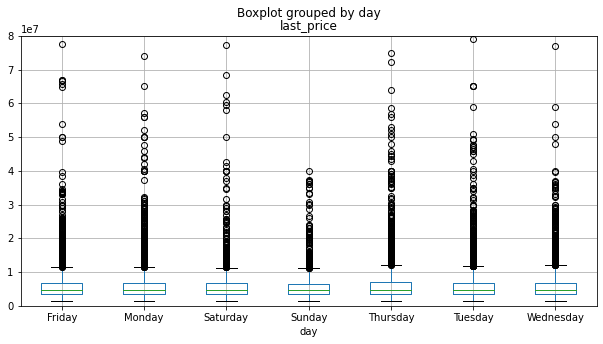

In [58]:
# посторим диаграмму размаха
plot = data.boxplot('last_price', by='day',figsize=(10,5)).set_ylim(0,80000000)

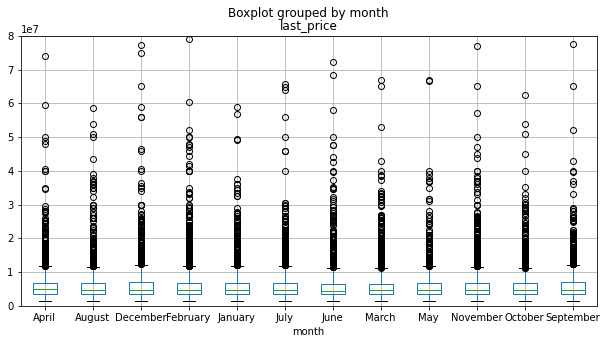

In [59]:
# посторим диаграмму размаха
plot = data.boxplot('last_price', by='month',figsize=(10,5)).set_ylim(0,80000000)

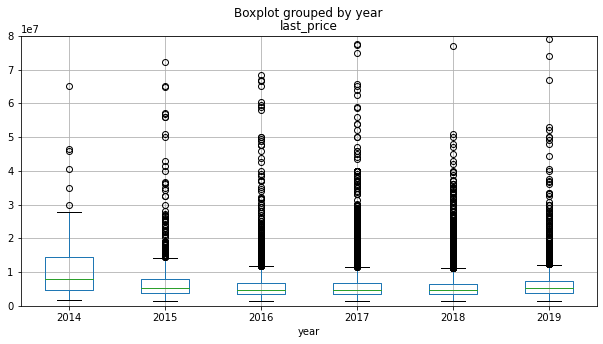

In [60]:
# посторим диаграмму размаха
plot = data.boxplot('last_price', by='year',figsize=(10,5)).set_ylim(0,80000000)

**Вывод:**
* Посмею предположить, что на стоимость квартиры в большей степени влияют следующие факторы: площадь квартиры и число комнат. Ну и отрицательная корреляция тоже имеет место быть. 
* Однозначно можно сказать, что дата размещения объявления не влияет на стоимость квартиры.
* С уверенностью можно сказать, что квартиры на первом этаже стоят дешевле.

<AxesSubplot:xlabel='year'>

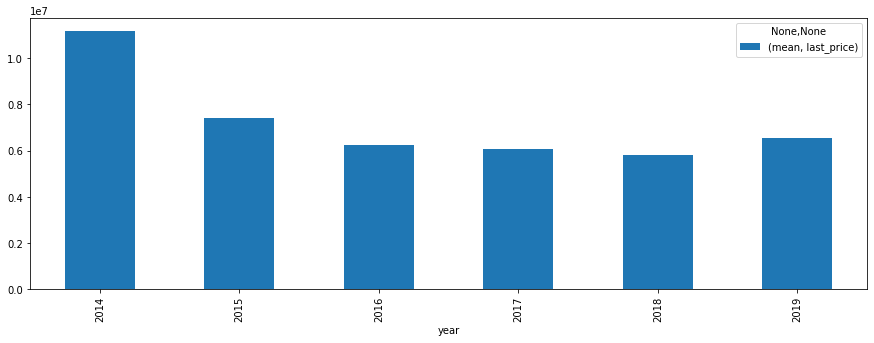

In [61]:
data_2 = data.pivot_table(index='year', values='last_price', aggfunc=['mean'])
data_2.plot(kind='bar', figsize=(15,5))

5. Посчитаем среднюю цену квадратного метра в населённых пунктах.

In [62]:
# найдем 10 населенных пунктов с наибольшим числом объявлений
data['locality_name'].value_counts().head(10)

Санкт-Петербург      15483
посёлок Мурино         522
посёлок Шушары         439
Всеволожск             393
Пушкин                 363
Колпино                337
посёлок Парголово      325
Гатчина                302
деревня Кудрово        299
Выборг                 226
Name: locality_name, dtype: int64

In [63]:
# посчитаем среднюю цену квадратного метра в этих населённых пунках
top_10_city = data['locality_name'].value_counts().head(10).index
data.query('locality_name in @top_10_city').groupby('locality_name').agg({'meter_price':'mean'}).sort_values(by='meter_price')

,meter_price
locality_name,
Выборг,59276.592920
Всеволожск,68971.361323
Гатчина,69471.168874
Колпино,75332.866469
посёлок Шушары,78655.132118
посёлок Мурино,85751.733716
посёлок Парголово,90430.298462
деревня Кудрово,92473.086957
Пушкин,103076.798898


**Вывод:**
Как можно было и догадаться, Санкт-Петербург оказался населенным пунктом, с самой высокой стоимостью жилья. Населенным пунктом из нашего списка, с самым низким уровнем жилья оказался Выборг

6. Выясним, какая область входит в центр.

In [64]:
# создадим столбец с расстоянием до центра в километрах
data['city_centers_nearest_km'] = data['city_centers_nearest'] / 1000
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype('int')
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,meter_price,day,month,year,floor_status,total_living_area_ratio,total_kitchen_area_ratio,city_centers_nearest_km
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.0,8,False records,...,755,95,120370,Thursday,March,2019,другой,0.472222,0.231481,16
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.6,1,False records,...,502,81,82920,Tuesday,December,2018,первый,0.460396,0.272277,18
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.3,4,False records,...,574,558,92785,Thursday,August,2015,другой,0.612500,0.148214,13
3,0,64900000,159.00,2015-07-24,3,2.65,14,45.0,9,False records,...,234,424,408176,Friday,July,2015,другой,0.283019,NaN,6
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.0,13,False records,...,48,121,100000,Tuesday,June,2018,другой,0.320000,0.410000,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23693,9,4600000,62.40,2016-08-05,3,2.60,9,40.0,8,False records,...,675,239,73717,Friday,August,2016,другой,0.641026,0.128205,34
23694,9,9700000,133.81,2017-03-21,3,3.70,5,73.3,3,False records,...,381,95,72490,Tuesday,March,2017,другой,0.547792,0.103356,4
23695,14,3100000,59.00,2018-01-15,3,2.65,5,38.0,4,False records,...,502,45,52542,Monday,January,2018,другой,0.644068,0.144068,13
23696,18,2500000,56.70,2018-02-11,2,2.65,3,29.7,1,False records,...,502,95,44091,Sunday,February,2018,первый,0.523810,NaN,13


In [65]:
# посчитаем среднюю цену для каждого километра
data.query('locality_name == "Санкт-Петербург"').groupby('city_centers_nearest_km').agg({'last_price':'mean'}).sort_values(by='last_price')

,last_price
city_centers_nearest_km,
26,3.575000e+06
29,3.833333e+06
24,3.862235e+06
25,4.014913e+06
23,4.126867e+06
19,4.678756e+06
17,4.843935e+06
28,4.910500e+06
18,5.002501e+06


<AxesSubplot:xlabel='city_centers_nearest_km'>

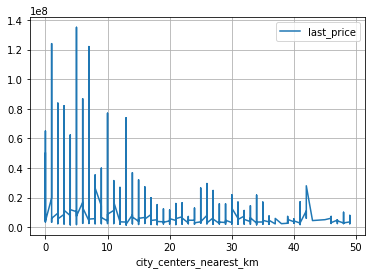

In [66]:
# построим график зависимости цены от удаленности от центра
data.sort_values('city_centers_nearest_km').plot(x='city_centers_nearest_km', y='last_price', grid=True, )

**Вывод:**
График показал нам зависимость цены от удаленности от центра, чем дальше квартира находится от центра, тем дешевле ее цена. К центральной области мы относим квартиры, которые находятся в пределах  5-6 километров, так как именно на этих границах график сильно меняется.

7. Выделим сегмент квартир в центре.

In [68]:
#выделим квартиры в центре, беря за радиус 6 км
center_spb_data = data.query('city_centers_nearest_km <= 6 and locality_name == "Санкт-Петербург"')

0.30864665880127046

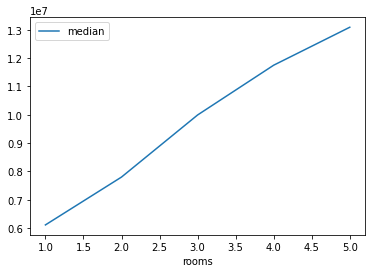

In [69]:
# зависимость стоимости квадратного метра от количества комнат
center_spb_rooms = center_spb_data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
center_spb_rooms.columns = ['mean', 'count', 'median']
center_spb_rooms.query('count > 50').plot(y = 'median')

center_spb_rooms.query('count > 50').sort_values('median', ascending = False)

center_spb_data['rooms'].corr(center_spb_data['last_price'])

**Вывод:** В центре СПБ чем меньше комнат тем дороже стоимость метра квадратного, в отличие от всей выборки, где стоимость уменьшается в зависимости от близости кол-ва комнат к 3.

,mean,count,median
floor_status,,,
другой,1.264674e+07,2208,9500000
первый,8.741411e+06,364,6717800
последний,1.168355e+07,552,8900000


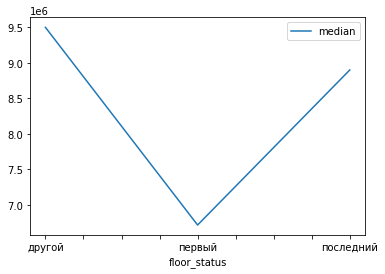

In [72]:
# зависимость стоимости квадратного метра от этажа
center_spb_floor_category = center_spb_data.pivot_table(index = 'floor_status', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
center_spb_floor_category.columns = ['mean', 'count', 'median']
center_spb_floor_category.plot(y = 'median')
center_spb_floor_category

 **Вывод:** 
 Квартиры на первом этаже в среднем дешевле, чем на последнем!

0.02667747892402133

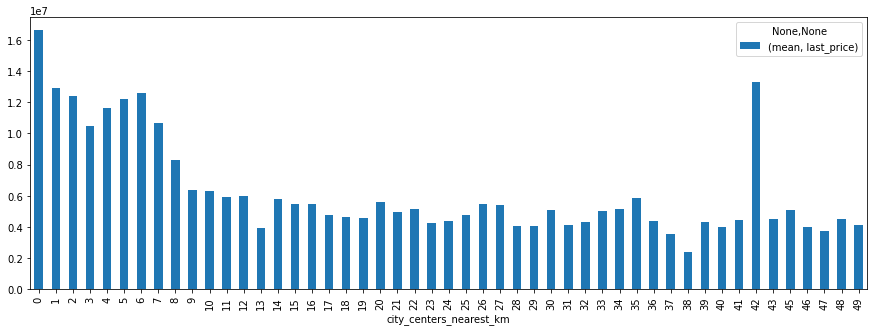

In [73]:
# квартиры на первом этаже в среднем дешевле, чем на последнем!
data_1 = data.pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc=['mean'])
data_1.plot(kind='bar', figsize=(15,5))
center_spb_data['city_centers_nearest'].corr(center_spb_data['meter_price'])

**Вывод:** Ожидаемо, четкой зависимости нет, так как у нас уже сделана выборка по центру города.

,mean,count,median
day,,,
Sunday,1.229774e+07,168,9315000
Monday,1.232662e+07,486,9200000
Tuesday,1.190065e+07,531,9000000
Thursday,1.252571e+07,640,8948000
Wednesday,1.156382e+07,546,8945131
Friday,1.159922e+07,528,8900000
Saturday,1.210885e+07,225,8500000


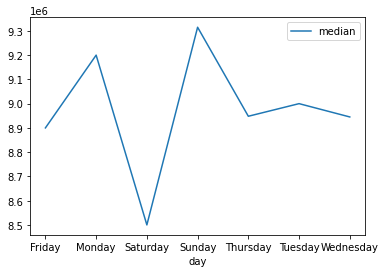

In [74]:
# зависимость стоимости квадратного метра от дня недели размещения объявления
center_spb_weekday_exposition = center_spb_data.pivot_table(index = 'day', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
center_spb_weekday_exposition.columns = ['mean', 'count', 'median']
center_spb_weekday_exposition.plot(y = 'median')

center_spb_weekday_exposition.sort_values('median', ascending = False)

**Вывод:** Ситуация отличается от всей выборки, минимальная средняя цена во вторник, а самая высокая в субботу!

,mean,count,median
month,,,
January,1.276362e+07,188,9900000
February,1.326414e+07,350,9445000
September,1.167924e+07,275,9400000
November,1.244367e+07,314,9380000
March,1.169548e+07,332,9300000
July,1.205145e+07,247,9000000
August,1.221675e+07,229,8900000
April,1.129255e+07,293,8750000
October,1.151915e+07,259,8550000


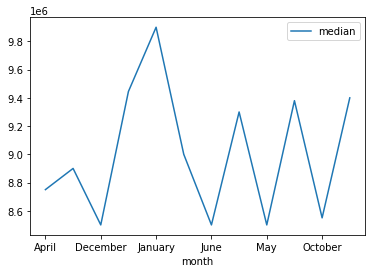

In [75]:
# зависимость стоимости квадратного метра от месяца размещения объявления
center_spb_month_exposition = center_spb_data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
center_spb_month_exposition.columns = ['mean', 'count', 'median']
center_spb_month_exposition.plot(y = 'median')

center_spb_month_exposition.sort_values('median', ascending = False)

**Вывод:** Самая высокая стоимость метра в январе и июле, самая низкая стоимость в июне.

,mean,count,median
year,,,
2015,1.345831e+07,272,9816985
2019,1.357333e+07,341,9500000
2016,1.133493e+07,430,9000000
2017,1.208814e+07,1113,8900000
2018,1.105037e+07,944,8700000


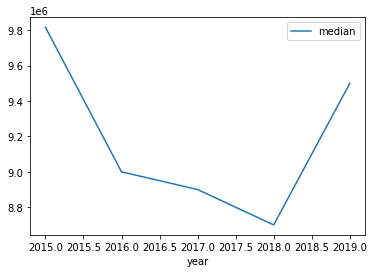

In [76]:
# зависимость стоимости квадратного метра от года размещения объявления
center_spb_year_exposition = center_spb_data.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
center_spb_year_exposition.columns = ['mean', 'count', 'median']
center_spb_year_exposition.query('count > 50').plot(y = 'median')

center_spb_year_exposition.query('count > 50').sort_values('median', ascending = False)

**Вывод:** Мы видим пропорциональный увеличение цен с 2016 года.

## Общий вывод

* Мы обработали полученный архив данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для удобной работы.
* Мы выявили, что на рыночную стоимость квадратного метра квартиры больше всего влияют количество комнат, этаж квартиры, близость к центру.
* Предполагаю, большое количество объявлений было автоматически снято с Яндекс Недвижимость и дату из снятия нельзя считать датой продажи квартиры.
* Также важно учитывать, что, рассматривая среднюю стоимость квартир в 2014-2019 годах, мы не делали сегментацию рынка, а лишь смотрели средние показатели по рынку в целом, т.е. возможно, что цены на аналогичные квартиры в разных годах вели себя абсолютно по-разному.
* Мы узнали, что квартиры на первом этаже стоят дешевле!
* В Санкт-Петербурге самые дорогие квартиры.